##**JASH SHAH**
##**UID-U01859286**
# **STANDARD GENERATIVE ADVERSARIAL NETWORK (GAN)**

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt


170498071/170498071 [==============================] - 13s 0us/step


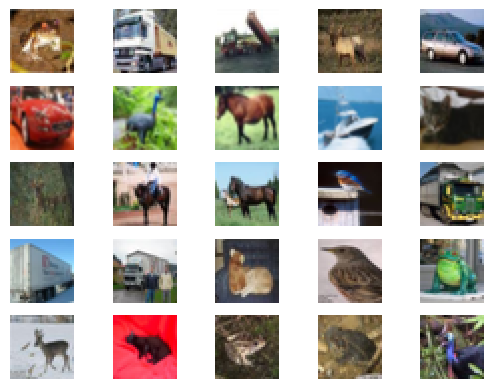

In [ ]:
(trainX, trainy), (testX, testy) = load_data()

for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

# **DEFINING DISCRIMINATOR AND SUMMARY**

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

# **DEFINING GENERATOR AND ITS SUMMARY**

In [ ]:
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
	return model
test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

# **COMBINING GENERATOR AND DISCRIMINATOR**

In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5
	return X


# **DEFINING REAL IMAGES**

In [ ]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y


# **DEFINIG THE LATENT POINTS**

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# **DEFINING FAKE IMAGES**

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

# **TRAINING BOTH GENERATOR AND DISCRIMINATOR AND SAVING THE MODEL FURTHER RUNNIG THE EPOCHS**

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	g_model.save('cifar_generator_2epochs.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=100)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 231/390, d1=0.696, d2=0.694 g=0.697
2/2 [==============================] - 0s 7ms/step
Epoch>94, Batch 232/390, d1=0.692, d2=0.696 g=0.698
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 233/390, d1=0.697, d2=0.699 g=0.696
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 234/390, d1=0.700, d2=0.694 g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 235/390, d1=0.689, d2=0.698 g=0.695
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 236/390, d1=0.696, d2=0.696 g=0.695
2/2 [==============================] - 0s 8ms/step
Epoch>94, Batch 237/390, d1=0.697, d2=0.696 g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 238/390, d1=0.699, d2=0.692 g=0.697
2/2 [==============================] - 0s 5ms/step
Epoch>94, Batch 239/390, d1=0.700, d2=0.689 g=0.702
2/2 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch>100, Batch 390/390, d1=0.697, d2=0.693 g=0.696


# **AFTER RUNNING THE EPOCHS WE GOT THE RESULTS AS**

---
### ***d1=0.695, d2=0.692 g=0.696***



# **PLOTING THE FINISHED IMAGE RESULTS AFTER THE RUNNING THE EPOCHS**

1/1 [==============================] - 0s 342ms/step


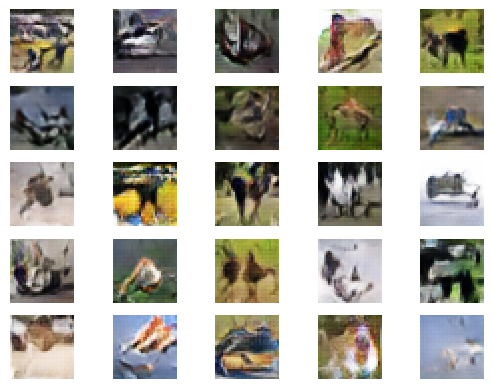

In [ ]:
from keras.models import load_model
from numpy.random import randn

def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
model = load_model('cifar_generator_2epochs.h5')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
show_plot(X, 5)

## **FRECHET INCEPTION DISTANCE (FID)**

In [ ]:
import numpy as np
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.datasets import cifar10
from scipy.linalg import sqrtm
from skimage.transform import resize
import gc

mobilenet_model = MobileNet(include_top=False, pooling='avg', input_shape=(128, 128, 3))

def preprocess_and_predict(model, images, new_shape, batch_size):
    activations = []
    for i in range(0, len(images), batch_size):
        end = i + batch_size
        resized_images = np.array([resize(image, new_shape, 0, preserve_range=True, anti_aliasing=True) for image in images[i:end]], dtype=np.float32)
        preprocessed_images = preprocess_input(resized_images)
        activations.append(model.predict(preprocessed_images))
        del resized_images, preprocessed_images
        gc.collect()
    return np.concatenate(activations, axis=0)


17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
def calculate_fid(model, images1, images2, batch_size=10):
    act1 = preprocess_and_predict(model, images1, (128, 128, 3), batch_size)
    act2 = preprocess_and_predict(model, images2, (128, 128, 3), batch_size)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid
(images_real, _), (_, _) = cifar10.load_data()
images_generated = X
fid = calculate_fid(mobilenet_model, images_real, images_generated, batch_size=10)
print('FID:', fid)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 419ms/step
FID: -1.5339921185425157e+52


# **WE GOT THE FID: -1.5339921185425157e+52**

##**INCEPTION SCORE (IS)**##

In [ ]:
import gc
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Activation
from keras.utils import to_categorical
base_model = MobileNet(include_top=False, pooling='avg', input_shape=(128, 128, 3))
input_tensor = Input(shape=(128, 128, 3))
x = base_model(input_tensor)
output_tensor = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output_tensor)

def preprocess_and_predict(model, images, new_shape, batch_size):
    activations = []
    predictions = []
    for i in range(0, len(images), batch_size):
        end = i + batch_size
        resized_images = np.array([resize(image, new_shape, 0, preserve_range=True, anti_aliasing=True) for image in images[i:end]], dtype=np.float32)
        preprocessed_images = preprocess_input(resized_images)
        pred = model.predict(preprocessed_images)
        predictions.extend(pred)
        del resized_images, preprocessed_images
        gc.collect()
    return np.concatenate(activations, axis=0), np.array(predictions)


In [ ]:
def preprocess_and_predict(model, images, new_shape, batch_size):
    activations = []
    predictions = []
    for i in range(0, len(images), batch_size):
        end = i + batch_size
        resized_images = np.array([resize(image, new_shape, 0, preserve_range=True, anti_aliasing=True) for image in images[i:end]], dtype=np.float32)
        preprocessed_images = preprocess_input(resized_images)
        pred = model.predict(preprocessed_images)
        predictions.extend(pred)
        activations.append(model.predict(preprocessed_images))
        del resized_images, preprocessed_images
        gc.collect()
    return np.concatenate(activations, axis=0), np.array(predictions)

In [ ]:
def calculate_inception_score(preds, num_splits=10):
    scores = []
    for i in range(num_splits):
        part = preds[i * (preds.shape[0] // num_splits): (i + 1) * (preds.shape[0] // num_splits)]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

_, preds_real = preprocess_and_predict(model, images_real, (128, 128, 3), batch_size=10)
_, preds_generated = preprocess_and_predict(model, images_generated, (128, 128, 3), batch_size=10)

is_mean, is_std = calculate_inception_score(preds_generated)

print('Inception Score:', is_mean, '+/-', is_std)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
Inception Score: 1.1778829 +/- 0.057102624


### **We got the Inception Score: 1.1778829 +/- 0.057102624**

# ***RESULTS***

---



### **DISCRIMINATOR AND GENERATOR ACCURACY VALUES WERE-d1=0.695, d2=0.692 g=0.696**

### **FID AND IS SCORE WERE FID: -1.5339921185425157e+52 AND Inception Score: 1.1778829 +/- 0.057102624**